# MOVIES INNIT MATE

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import xgboost as xgb

# IMPORT DATASETS

Just checking if feed_into_pipeline_data.csv is the same as feed_into_pipeline_data_withLang.csv but with Language and other features

In [2]:
df = pd.read_csv(os.path.relpath('../data/processed/feed_into_pipeline_data_withTags.csv'))
summaries = pd.read_csv(os.path.relpath('../data/interim/GlobalOriginalsWithSummary.csv'))[['combined_title', 'summary']]
people_rankings = pd.read_csv(os.path.relpath('../data/interim/showsWithPrinicpalRankings.csv'))[['combined_title', 'director_rank', 'writer_rank', 'actor_rank']]

# merge all 3 datasets
df = df.merge(summaries, on='combined_title')
df = df.merge(people_rankings, on='combined_title')
df.drop_duplicates(inplace=True)

# split into tv_shows only and sort by combined_title
movies = df[df['is_tv_show']==False]

# check if ordering before and after sorting by combined_title is the same
# tv_shows.sort_values(by='combined_title', inplace=True)
movies.reset_index(drop=True, inplace=True)
# tv_shows.head()

## Movies with <u>Rankings<u>

In [3]:
movies.head()

,combined_title,release_year,release_date,is_top10,lower_title,season,is_tv_show,tconst,averageRating,numVotes,...,nudity,violence,profanity,alcohol,frightening,language,summary,director_rank,writer_rank,actor_rank
0,The Ripper: Limited Series,2020,12/16/20,1,the ripper limited series,NaN,False,tt0084719,6.3,11269,...,Severe,Severe,Moderate,Mild,Severe,Italian,A burned-out New York police detective teams u...,2985.5,6699.833333,17924.666670
1,Army of the Dead,2021,5/21/21,1,army of the dead,NaN,False,tt0993840,5.7,172357,...,Mild,Severe,Severe,Mild,Severe,English,"Following a zombie outbreak in Las Vegas, a gr...",69.0,2450.666667,2647.666667
2,Guilty,2020,3/6/20,0,guilty,NaN,False,tt10062614,5.4,4482,...,Mild,Mild,Moderate,Moderate,Moderate,Hindi,When a college heartthrob is accused of rape b...,18040.5,19483.000000,24028.333330
3,Earth and Blood,2020,4/17/20,1,earth and blood,NaN,False,tt10092752,5.2,2646,...,None,Mild,Mild,Mild,Mild,French,"Saïd owns a sawmill deep in the woods, which h...",9434.0,31082.166670,15526.666670
4,Super Me,2021,4/9/21,1,super me,NaN,False,tt10097544,5.8,1669,...,None,Severe,Moderate,Moderate,Severe,Chinese,A young scriptwriter starts bringing valuable ...,32523.0,63963.500000,23165.500000


In [4]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst']

In [5]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])

# # split into training and validation sets
# tvshows_X_train, tvshows_X_val, tvshows_y_train, tvshows_y_val = train_test_split(tvshows_X_train, tvshows_y_train, test_size=0.2, random_state=42, stratify=tvshows_y_train)

# XGBOOST

### <u>XGBoost : No Summary<u>

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [82]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        #("bagofwords", CountVectorizer(stop_words='english', min_df=0.02), 'summary'),             # One hot encoding
        #("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),                                   # add genre information
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']), #impute missing values
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),      # one-hot encode language
    ],
    remainder='passthrough')

In [93]:
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_ns = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__n_estimators': [100, 200],
        'xgb__subsample': [0.8, 0.85, 0.9],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [94]:
# fit xgb_gs_ns and drop column = 'summary' from training set
xgb_gs_ns.fit(X_train.drop('summary', axis=1), y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:51:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('genres_count',
                                                                         CountVectorizer(min_df=0.01),
                                                                         'genres'),
                                                                        ('rankings_pipeline',
                                                                         P...
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.8, 0.85, 0.9]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [95]:
xgb_gs_ns.best_params_

{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.85}

In [96]:
# save best xgb_gs_ns model as a variable
best_xgb_gs_ns = xgb_gs_ns.best_estimator_

# output auc, f1-score, and accuracy on training set
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# output best score from xgb_gs_ns
print("XGBoost No Summary, Best score: %0.5f" % xgb_gs_ns.best_score_)

# output test set auc, f1-score, and accuracy
print("XGBoost No Summary, Test set AUC: %0.5f" % roc_auc_score(y_test, best_xgb_gs_ns.predict_proba(X_test.drop('summary', axis=1))[:,1]))
print("XGBoost No Summary, Test set F1: %0.5f" % f1_score(y_test, best_xgb_gs_ns.predict(X_test.drop('summary', axis=1))))
print("XGBoost No Summary, Test set Accuracy: %0.5f" % accuracy_score(y_test, best_xgb_gs_ns.predict(X_test.drop('summary', axis=1))))

XGBoost No Summary, Best score: 0.83002
XGBoost No Summary, Test set AUC: 0.82505
XGBoost No Summary, Test set F1: 0.77157
XGBoost No Summary, Test set Accuracy: 0.75543


### Keeping track of model params

Base - 0.81480

Remove Log Transform - 0.81476

Mean Imputation - 0.81920

Iterative Imputer - 0.81854

KNN Imputer - 0.82135

Genres 0.03 - 0.82235

Genres 0.01 - 0.82512

Subsample 0.9 - 0.82529

Subsample 0.85 - 0.83002


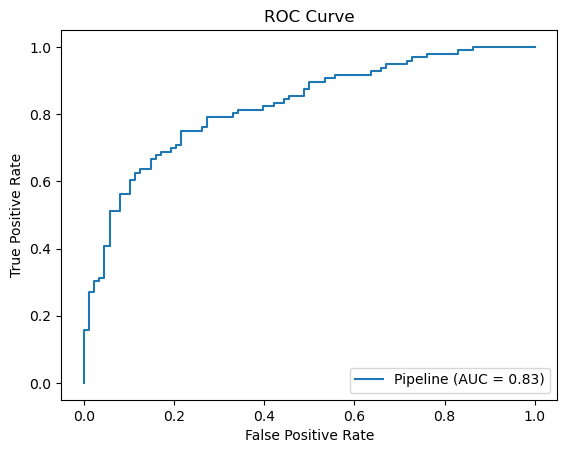

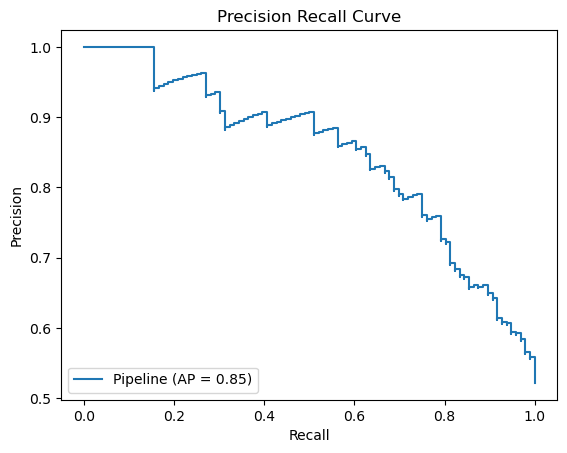

In [97]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_estimator(best_xgb_gs_ns, X_test.drop('summary', axis=1), y_test)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_estimator(best_xgb_gs_ns, X_test.drop('summary', axis=1), y_test)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_xgb_nosummary_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_xgb_nosummary_precision_recall_curve.png')

### <u>XGBoost : Bag of Words Summary<u>____________________________________________________________

In [593]:
# remove punctuation from summary
X_train['summary'] = X_train['summary'].str.replace('[^\w\s ]','', regex=True)

In [595]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        
class StemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, articles):
        return [self.stemmer.stem(t) for t in word_tokenize(articles)]


tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)



In [320]:
from sklearn.feature_extraction import text

custom_stop_words = []
# add lemmatized stop words to stop_words list

for i in text.ENGLISH_STOP_WORDS:
    custom_stop_words.append(SnowballStemmer('english').stem(i))

In [321]:
new_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

In [596]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        ("bagofwords", CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),      # one-hot encode language
    ],
    remainder='passthrough')

In [607]:
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_bow = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [2, 3, 4],
        'xgb__learning_rate': [0.01, 0.03, 0.05],
        'xgb__n_estimators': [100],
        'xgb__subsample': [0.85],
        'xgb__gamma': [0.2],
        'xgb_transformer__bagofwords__min_df': [0.01, 0.02],
        'xgb_transformer__rankings_pipeline__imputer__n_neighbors': [5],

    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [608]:
# fit xgb_gs_bow to training set
xgb_gs_bow.fit(X_train, y_train)

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:02:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('bagofwords',
                                                                         CountVectorizer(stop_words='english',
                                                                                         tokenizer=<__main__.LemmaT...
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0.2],
                         'xgb__learning_rate': [0.01, 0.03, 0.05],
                         'xgb__max_depth': [2, 3, 4],
                         'xgb__n_estimators': [100], 'xgb__subsample': [0.85],
                         'xgb_transformer__bagofwords__min_df': [0.01, 0.02],
                         'xgb_transformer__rankings_pipeline__imputer__n_neighbors': [5]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [609]:
xgb_gs_bow.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.85,
 'xgb_transformer__bagofwords__min_df': 0.02,
 'xgb_transformer__rankings_pipeline__imputer__n_neighbors': 5}

In [610]:
# save best xgb_gs_bow model as a variable
best_xgb_gs_bow = xgb_gs_bow.best_estimator_

# output auc, f1-score, and accuracy on training set
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# output best score from xgb_gs_bow
print("XGBoost Bag of Words, Best score: %0.5f" % xgb_gs_bow.best_score_)

# output test set auc, f1-score, and accuracy
print("XGBoost Bag of Words, Test set AUC: %0.5f" % roc_auc_score(y_test, best_xgb_gs_bow.predict_proba(X_test)[:,1]))
print("XGBoost Bag of Words, Test set F1: %0.5f" % f1_score(y_test, best_xgb_gs_bow.predict(X_test)))
print("XGBoost Bag of Words, Test set Accuracy: %0.5f" % accuracy_score(y_test, best_xgb_gs_bow.predict(X_test)))

XGBoost Bag of Words, Best score: 0.82888
XGBoost Bag of Words, Test set AUC: 0.81925
XGBoost Bag of Words, Test set F1: 0.76531
XGBoost Bag of Words, Test set Accuracy: 0.75000


In [384]:
best_xgb_gs_bow['xgb'].save_model('../models/movie_xgb_gs_bow.model')

### Saving Experiments

Base - 0.82550

BOW 0.04 - 0.83039

Lemmatizing - 0.83309

Cleaned lemmatizing - 0.83117

Stemming 0.05 - 0.83260 

Cleaned Stemming - 0.83298

Tuning Gamma and Eta - 0.83321

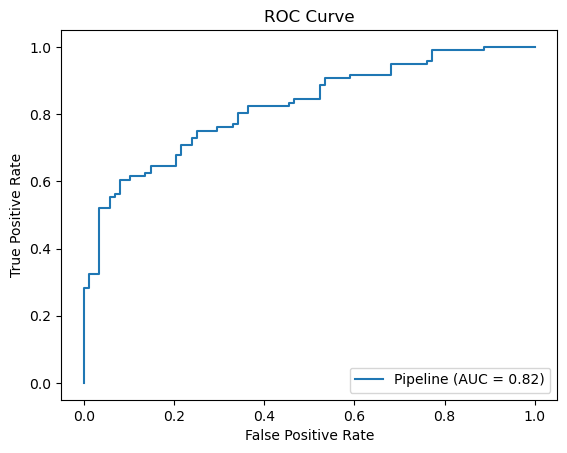

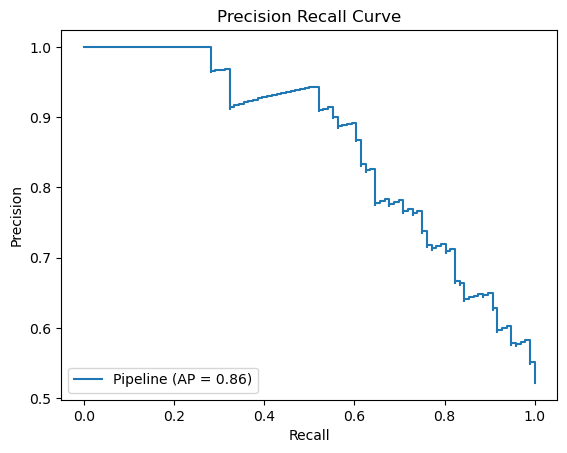

In [577]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_estimator(best_xgb_gs_bow, X_test, y_test)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_estimator(best_xgb_gs_bow, X_test, y_test)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_xgb_bow_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_xgb_bow_precision_recall_curve.png')

In [613]:
"test" + best_xgb_gs_bow['xgb_transformer'].transformers_[2][1].get_feature_names_out()

array(['testbegin', 'testbest', 'testboy', 'testbrother', 'testcareer',
       'testchild', 'testchristmas', 'testcity', 'testcome',
       'testcomedian', 'testcomedy', 'testcop', 'testcrime',
       'testdaughter', 'testday', 'testdocumentary', 'testdream',
       'testface', 'testfall', 'testfamily', 'testfather', 'testfight',
       'testfilm', 'testfollows', 'testfriend', 'testfuture', 'testgirl',
       'testgroup', 'testha', 'testhelp', 'testhigh', 'testhome',
       'testjoin', 'testjourney', 'testjust', 'testlearn', 'testlife',
       'testlike', 'testliving', 'testlook', 'testlove', 'testmake',
       'testman', 'testmeet', 'testmother', 'testmysterious', 'testnew',
       'testnight', 'testold', 'testpast', 'testpeople', 'testplace',
       'testpolice', 'testreal', 'testrelationship', 'testreturn',
       'testsave', 'testschool', 'testsearch', 'testsecret', 'testset',
       'testsocial', 'testson', 'testspecial', 'teststage', 'teststandup',
       'teststart', 'teststory'

In [18]:
def get_feature_names(estimator, numeric_features=['release_year', 'titleType', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'actor_rank', 'writer_rank']):
    """Get feature names from a pipeline or column transformer."""
    feature_names = []
    for transformer in estimator.transformers_:
        try:
            if transformer[0] == 'rankings_pipeline':
                feature_names.append(['director_rank', 'actor_rank', 'writer_rank'])
            elif type(transformer[1]) == CountVectorizer:
                feature_names.append(transformer[2] + "_" + transformer[1].get_feature_names_out())
            else:
                feature_names.append(transformer[1].get_feature_names_out())
        except:
            pass
    feature_names = np.concatenate(feature_names)
    unchanged_features = [feature for feature in estimator.feature_names_in_ if feature not in numeric_features]
    feature_names = np.concatenate([feature_names, unchanged_features])
    return feature_names

In [620]:
xgb_gs_bow_feature_names = get_feature_names(best_xgb_gs_bow['xgb_transformer'])

In [621]:
explainer = shap.TreeExplainer(best_xgb_gs_bow['xgb'])

shap_values = explainer.shap_values(xgb.DMatrix(best_xgb_gs_bow['xgb_transformer'].transform(X_test), y_test))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


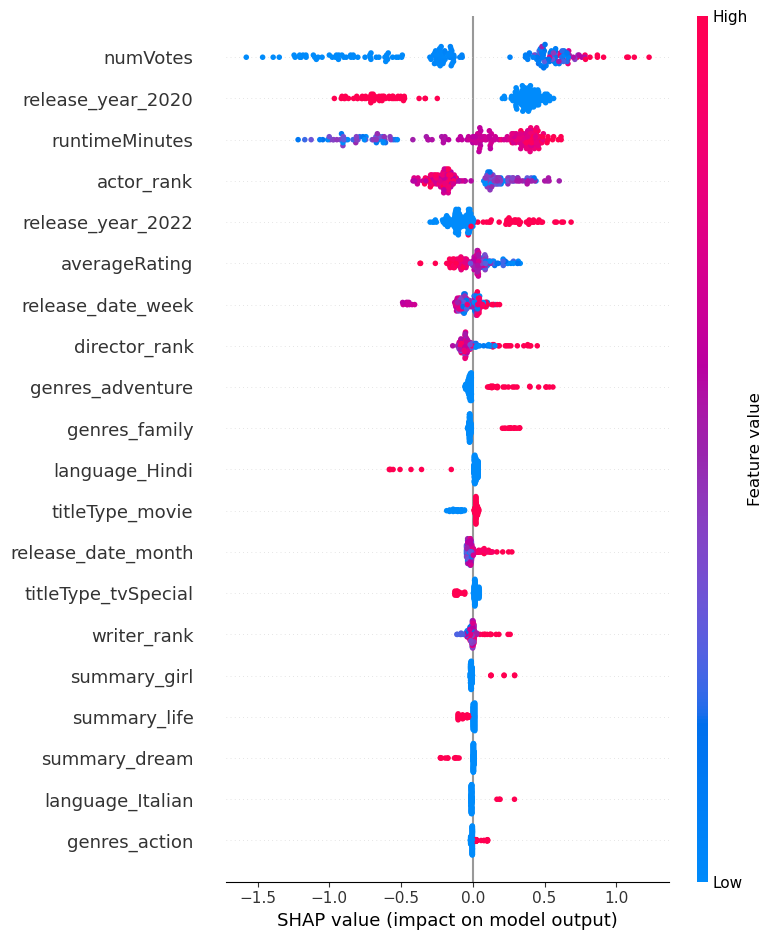

In [622]:
shap.summary_plot(shap_values, pd.DataFrame(best_xgb_gs_bow['xgb_transformer'].transform(X_test).todense(), columns=xgb_gs_bow_feature_names))

In [623]:
### <u>XGBoost : TFIDF Summary<u>___________________________________________________________________

In [627]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('missingimputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        #("bagofwords", CountVectorizer(stop_words='english', min_df=0.02), 'summary'),              # One hot encoding
        ("tfidf", TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english'), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language
    ],
    remainder='passthrough')

In [628]:
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_tfidf = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [2, 3, 4],
        'xgb__learning_rate': [0.01, 0.03, 0.05],
        'xgb__n_estimators': [50, 100, 200],
        'xgb_transformer__tfidf__min_df': [0.02, 0.03, 0.04],
        'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5, 10, 15],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [629]:
# fit xgb_gs_bow to training set
xgb_gs_tfidf.fit(X_train, y_train)

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:17:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('tfidf',
                                                                         TfidfVectorizer(stop_words='english',
                                                                                         tokenizer=<__main__.LemmaTokeni...
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.03, 0.05],
                         'xgb__max_depth': [2, 3, 4],
                         'xgb__n_estimators': [50, 100, 200],
                         'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5,
                                                                                             10,
                                                                                             15],
                         'xgb_transformer__tfidf__min_df': [0.02, 0.03, 0.04]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [630]:
xgb_gs_tfidf.best_params_

{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 100,
 'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': 5,
 'xgb_transformer__tfidf__min_df': 0.04}

In [631]:
# save best xgb_gs_tfidf model as a variable
best_xgb_gs_tfidf = xgb_gs_tfidf.best_estimator_

# output best score from xgb_gs_tfidf
print("XGBoost TF-IDF, Best score: %0.5f" % xgb_gs_tfidf.best_score_)

# output test set auc, f1-score, and accuracy
print("XGBoost TF-IDF, Test set AUC: %0.5f" % roc_auc_score(y_test, best_xgb_gs_tfidf.predict_proba(X_test)[:,1]))
print("XGBoost TF-IDF, Test set F1: %0.5f" % f1_score(y_test, best_xgb_gs_tfidf.predict(X_test)))
print("XGBoost TF-IDF, Test set Accuracy: %0.5f" % accuracy_score(y_test, best_xgb_gs_tfidf.predict(X_test)))

XGBoost TF-IDF, Best score: 0.82292
XGBoost TF-IDF, Test set AUC: 0.81570
XGBoost TF-IDF, Test set F1: 0.74490
XGBoost TF-IDF, Test set Accuracy: 0.72826


### Saving Experiments

Base - 0.82466

Lemmatizer, 15 KNN - 0.82709

Cleaned Lemmatizer - 0.82292

Cleaned Stemmer - 0.82240

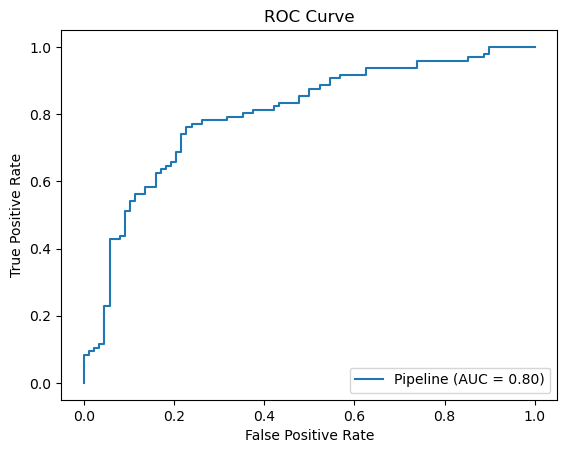

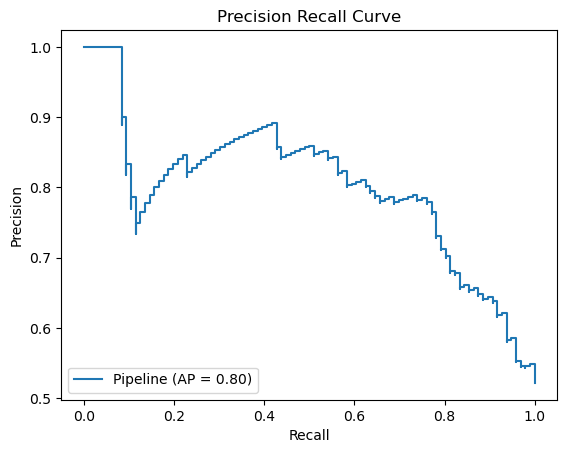

In [338]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_estimator(best_xgb_gs_tfidf, X_test, y_test)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_estimator(best_xgb_gs_tfidf, X_test, y_test)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_xgb_tfidf_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_xgb_tfidf_precision_recall_curve.png')

## <u>XGBoost : FIne Tuned BERT Summary<u>

In [264]:
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

loading configuration file config.json from cache at C:\Users\Joeyz/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\Joeyz/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

In [265]:
X_train_no_sum = X_train.drop(columns=['summary'])
X_train_no_sum['summary'] = X_train['summary']

In [266]:
X_train_no_sum['text'] = X_train_no_sum.astype(str).apply('. '.join, axis=1)
X_train_no_sum['label'] = y_train

In [267]:
# Split into train and validation sets
train_df, val_df = train_test_split(X_train_no_sum, test_size=0.2)

In [268]:
X_test_no_sum = X_test.drop(columns=['summary'])
X_test_no_sum['summary'] = X_test['summary']
X_test_no_sum['text'] = X_test_no_sum.astype(str).apply('. '.join, axis=1)
X_test_no_sum['label'] = y_test

In [269]:
from datasets import Dataset

# load test set
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(X_test_no_sum[['text', 'label']])

In [270]:
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)


In [283]:
train_dataset = train_dataset.map(tokenize_function)
val_dataset = val_dataset.map(tokenize_function)
test_dataset = test_dataset.map(tokenize_function)



















100%|██████████| 586/586 [00:00<00:00, 675.45ex/s]






100%|██████████| 147/147 [00:00<00:00, 701.87ex/s]






100%|██████████| 184/184 [00:00<00:00, 778.30ex/s]


In [287]:
from transformers import TrainingArguments

training_args = TrainingArguments("full_training")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [288]:
from transformers import Trainer

full_trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset )

In [289]:
from transformers.integrations import MLflowCallback

full_trainer.remove_callback(MLflowCallback)

In [292]:
full_trainer.train()

***** Running training *****
  Num examples = 586
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 222
  Number of trainable parameters = 109483778



  0%|          | 1/222 [01:33<5:44:28, 93.52s/it]
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.











































































































































































































































































































































































{'train_runtime': 7094.4599, 'train_samples_per_second': 0.248, 'train_steps_per_second': 0.031, 'train_loss': 0.4989266954026781, 'epoch': 3.0}


TrainOutput(global_step=222, training_loss=0.4989266954026781, metrics={'train_runtime': 7094.4599, 'train_samples_per_second': 0.248, 'train_steps_per_second': 0.031, 'train_loss': 0.4989266954026781, 'epoch': 3.0})

In [293]:
full_trainer.save_model('full_training_bert')

Saving model checkpoint to full_training_bert
Configuration saved in full_training_bert\config.json
Model weights saved in full_training_bert\pytorch_model.bin


In [294]:
val_preds = full_trainer.predict(val_dataset)
val_preds_proba = val_preds.predictions[:,1]

***** Running Prediction *****
  Num examples = 147
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.






































100%|██████████| 19/19 [03:55<00:00, 12.42s/it]


In [295]:
#calculate auc

from sklearn.metrics import roc_auc_score

roc_auc_score(val_df['label'], val_preds_proba)

0.6049795615013005

In [296]:
test_preds = full_trainer.predict(test_dataset)
test_preds_proba = test_preds.predictions[:,1]

***** Running Prediction *****
  Num examples = 184
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.














































100%|██████████| 23/23 [05:02<00:00, 13.16s/it]


In [297]:
roc_auc_score(X_test_no_sum['label'], test_preds_proba)

0.6425189393939393

In [11]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def get_results_model(model, X_test=X_test, y_test=y_test, name=""):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print(f"{name} AUC: %0.5f" % roc_auc_score(y_test, y_pred_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_test, y_pred))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_test, y_pred))
    return y_pred, y_pred_proba

def get_results_preds(y_labels, y_preds_proba, y_preds,  name=""):

    print(f"{name} AUC: %0.5f" % roc_auc_score(y_labels, y_preds_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_labels, y_preds))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_labels, y_preds))

In [340]:
get_results_preds(X_test_no_sum['label'], test_preds_proba, np.argmax(test_preds.predictions, axis=1), "Fine Tuned BERT Test")

Fine Tuned BERT Test AUC: 0.64252
Fine Tuned BERT Test F1: 0.66010
Fine Tuned BERT Test Accuracy: 0.62500


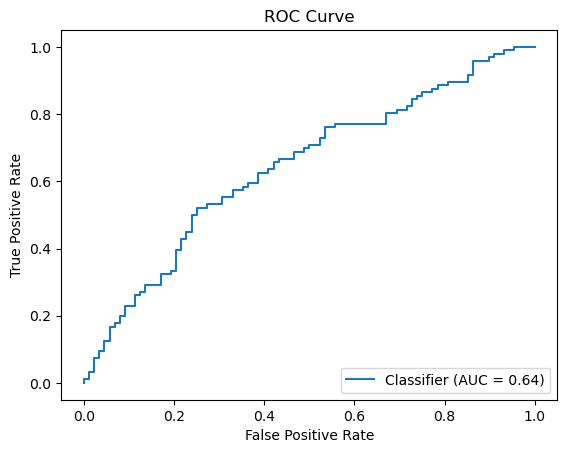

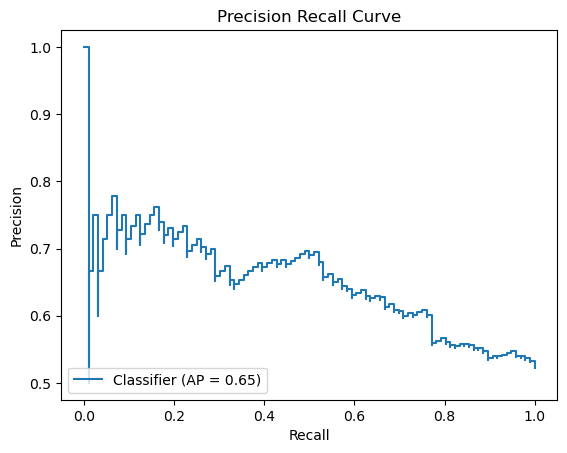

In [341]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_predictions(X_test_no_sum['label'], test_preds_proba)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_predictions(X_test_no_sum['label'], test_preds_proba)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_xgb_BERT_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_xgb_BERT_precision_recall_curve.png')

## Straight up Using a model from online

In [633]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
model = AutoModelForSequenceClassification.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")

loading configuration file config.json from cache at C:\Users\Joeyz/.cache\huggingface\hub\models--joeddav--distilbert-base-uncased-go-emotions-student\snapshots\8f145be763be749ae21d1209758c855d5ddf1b9c\config.json
Model config DistilBertConfig {
  "_name_or_path": "joeddav/distilbert-base-uncased-go-emotions-student",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "admiration",
    "1": "amusement",
    "2": "anger",
    "3": "annoyance",
    "4": "approval",
    "5": "caring",
    "6": "confusion",
    "7": "curiosity",
    "8": "desire",
    "9": "disappointment",
    "10": "disapproval",
    "11": "disgust",
    "12": "embarrassment",
    "13": "excitement",
    "14": "fear",
    "15": "gratitude",
    "16": "grief",
    "17": "joy",
    "18": "love",
    "19": "nervousness",
    "20": "optimism",
    "21": "pride",
    "22": "reali

In [647]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, top_k=None, )

In [692]:
result = classifier(X_train['summary'].tolist())

In [695]:
sorted_result = [sorted(i, key=lambda d: d['label']) for i in result]

In [739]:
scores = pd.DataFrame(sorted_result).stack().apply(lambda x: x['score']).unstack()
scores.columns = ["emotion_"+i['label'] for i in sorted_result[0]]

In [751]:
new_X_train = pd.concat([X_train.reset_index(drop=True), scores.reset_index(drop=True)], axis=1)

In [752]:
new_X_train

,release_year,averageRating,numVotes,titleType,runtimeMinutes,genres,release_date_quarter,release_date_month,release_date_week,nudity,...,emotion_love,emotion_nervousness,emotion_neutral,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise
0,2020,6.8,14383,movie,94.0,Drama,4,11,46,None,...,0.006049,0.018581,0.009885,0.007810,0.011741,0.050347,0.012076,0.039911,0.070121,0.046878
1,2021,7.1,2671,movie,129.0,"Drama,Music",2,4,17,Moderate,...,0.011272,0.019733,0.011963,0.008293,0.017404,0.016252,0.007427,0.053980,0.152652,0.034301
2,2022,4.9,18888,movie,110.0,"Drama,Sci-Fi,Thriller",1,1,1,Mild,...,0.004313,0.094243,0.006982,0.005746,0.009237,0.041693,0.008150,0.053576,0.054807,0.040875
3,2021,4.5,86,tvSpecial,64.0,Comedy,4,10,41,None,...,0.014581,0.003512,0.010728,0.091798,0.057246,0.024170,0.050003,0.008940,0.001308,0.034753
4,2020,7.1,671,movie,94.0,"Biography,Documentary,Sport",4,10,44,None,...,0.007490,0.016423,0.008791,0.010619,0.021333,0.033617,0.009682,0.055097,0.032494,0.035773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,2021,6.4,7210,movie,93.0,"Biography,Documentary,Music",3,9,39,None,...,0.013645,0.020582,0.021446,0.015037,0.038384,0.083065,0.023755,0.048803,0.011901,0.040463
729,2022,6.3,3846,movie,100.0,"Action,Crime,Drama",2,4,17,None,...,0.005950,0.028060,0.010629,0.009956,0.017772,0.069013,0.018586,0.035060,0.019348,0.052968
730,2020,4.0,223,movie,101.0,"Action,Comedy,Romance",4,10,40,None,...,0.080107,0.016412,0.009958,0.007832,0.014438,0.053550,0.008589,0.050574,0.044496,0.061006
731,2022,7.1,65161,movie,114.0,"Crime,Documentary",1,2,5,None,...,0.007125,0.021254,0.008393,0.008909,0.019009,0.043183,0.010479,0.028447,0.020828,0.045895


In [753]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('missingimputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        ("bagofwords", CountVectorizer(stop_words='english'), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english'), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language
    ],
    remainder='passthrough')

In [768]:
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_bow_emotions = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3],
        'xgb__learning_rate': [0.01, 0.03, 0.05],
        'xgb__n_estimators': [100],
        'xgb__subsample': [0.8, 0.85, 0.9],
        'xgb_transformer__bagofwords__min_df': [0.02, 0.03, 0.04],
        'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5, 10, 15],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [769]:
# fit xgb_gs_bow to training set
xgb_gs_bow_emotions.fit(new_X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:28:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('bagofwords',
                                                                         CountVectorizer(stop_words='english'),
                                                                         'summary'),
                                                                        ('genres_count...
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.03, 0.05],
                         'xgb__max_depth': [3], 'xgb__n_estimators': [100],
                         'xgb__subsample': [0.8, 0.85, 0.9],
                         'xgb_transformer__bagofwords__min_df': [0.02, 0.03,
                                                                 0.04],
                         'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5,
                                                                                             10,
                                                                                             15]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [771]:
xgb_gs_bow_emotions.best_params_

{'xgb__learning_rate': 0.03,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.9,
 'xgb_transformer__bagofwords__min_df': 0.03,
 'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': 15}

In [772]:
# save best xgb_gs_tfidf model as a variable
best_xgb_bow_emotions = xgb_gs_bow_emotions.best_estimator_

# output best score from xgb_gs_tfidf
print("XGBoost TF-IDF, Best score: %0.5f" % xgb_gs_bow_emotions.best_score_)

# output test set auc, f1-score, and accuracy
print("XGBoost TF-IDF, Test set AUC: %0.5f" % roc_auc_score(y_test, best_xgb_bow_emotions.predict_proba(X_test)[:,1]))
print("XGBoost TF-IDF, Test set F1: %0.5f" % f1_score(y_test, best_xgb_bow_emotions.predict(X_test)))
print("XGBoost TF-IDF, Test set Accuracy: %0.5f" % accuracy_score(y_test, best_xgb_bow_emotions.predict(X_test)))

XGBoost TF-IDF, Best score: 0.80240


ValueError: columns are missing: {'emotion_annoyance', 'emotion_disgust', 'emotion_desire', 'emotion_amusement', 'emotion_embarrassment', 'emotion_excitement', 'emotion_neutral', 'emotion_pride', 'emotion_nervousness', 'emotion_confusion', 'emotion_sadness', 'emotion_grief', 'emotion_approval', 'emotion_relief', 'emotion_remorse', 'emotion_optimism', 'emotion_caring', 'emotion_joy', 'emotion_realization', 'emotion_admiration', 'emotion_curiosity', 'emotion_fear', 'emotion_disapproval', 'emotion_surprise', 'emotion_disappointment', 'emotion_gratitude', 'emotion_love', 'emotion_anger'}

In [759]:
best_xgb_bow_emotions['xgb']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## XGB with No Summary, No Reviews or Votes

In [29]:

rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('missingimputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        #("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year

        #("bagofwords", CountVectorizer(stop_words='english'), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english'), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language
    ],
    remainder='passthrough')
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_ns_drop = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3,4,5],
        'xgb__learning_rate': [0.03, 0.05],
        'xgb__n_estimators': [100],
        'xgb__subsample': [0.8, 0.85, 0.9],
        #'xgb_transformer__bagofwords__min_df': [0.01, 0.015, 0.02],
        'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5, 10, 15],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [30]:
# fit xgb_gs_bow to training set
xgb_gs_ns_drop.fit(X_train.drop(columns=['summary', 'averageRating', 'numVotes']), y_train)
xgb_gs_ns_drop.best_params_

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:03:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.8,
 'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': 10}

In [31]:
# save best xgb_gs_bow model as a variable
best_xgb_gs_ns_drop = xgb_gs_ns_drop.best_estimator_

# output auc, f1-score, and accuracy on training set
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# output best score from xgb_gs_bow
print("XGBoost No Summary, Best score: %0.5f" % xgb_gs_ns_drop.best_score_)

y_pred, y_pred_proba = get_results_model(best_xgb_gs_ns_drop, X_test.drop(columns=['averageRating', 'numVotes']))

XGBoost No Summary, Best score: 0.81205
 AUC: 0.81652
 F1: 0.76142
 Accuracy: 0.74457


## XGB with BOW, No Reviews or Votes

In [21]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('missingimputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        #("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year

        ("bagofwords", CountVectorizer(stop_words='english'), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english'), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language
    ],
    remainder='passthrough')
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_bow_drop = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3,4,5],
        'xgb__learning_rate': [0.03, 0.05],
        'xgb__n_estimators': [100],
        'xgb__subsample': [0.8, 0.85, 0.9],
        'xgb_transformer__bagofwords__min_df': [0.01, 0.015, 0.02],
        'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5, 10, 15],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)
# fit xgb_gs_bow to training set
xgb_gs_bow_drop.fit(X_train.drop(columns=['averageRating', 'numVotes']), y_train)
xgb_gs_bow_drop.best_params_

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:36:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.85,
 'xgb_transformer__bagofwords__min_df': 0.02,
 'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': 15}

In [23]:
# save best xgb_gs_bow model as a variable
best_xgb_gs_bow_drop = xgb_gs_bow_drop.best_estimator_

# output auc, f1-score, and accuracy on training set
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# output best score from xgb_gs_bow
print("XGBoost Bag of Words, Best score: %0.5f" % xgb_gs_bow_drop.best_score_)

y_pred, y_pred_proba = get_results_model(best_xgb_gs_bow_drop, X_test.drop(columns=['averageRating', 'numVotes']))

XGBoost Bag of Words, Best score: 0.81145
 AUC: 0.82055
 F1: 0.75510
 Accuracy: 0.73913


Baseline: 0.81053

Resetting year to int: 0.81107

Not cleaning text: 0.81145

In [46]:
explainer = shap.TreeExplainer(best_xgb_gs_bow_drop['xgb'], best_xgb_gs_bow_drop['xgb_transformer'].transform(X_test), model_output='probability')

ValueError: setting an array element with a sequence.

In [41]:
explainer = shap.TreeExplainer(best_xgb_gs_bow_drop['xgb'], model_output="probability")

shap_values = explainer.shap_values(xgb.DMatrix(best_xgb_gs_bow_drop['xgb_transformer'].transform(X_test.drop(columns=['averageRating', 'numVotes'])), y_test))

ValueError: Only model_output="raw" is supported for feature_perturbation="tree_path_dependent"

In [25]:
xgb_gs_bow_drop_feature_names = get_feature_names(best_xgb_gs_bow_drop['xgb_transformer'], ['titleType', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'actor_rank', 'writer_rank'])

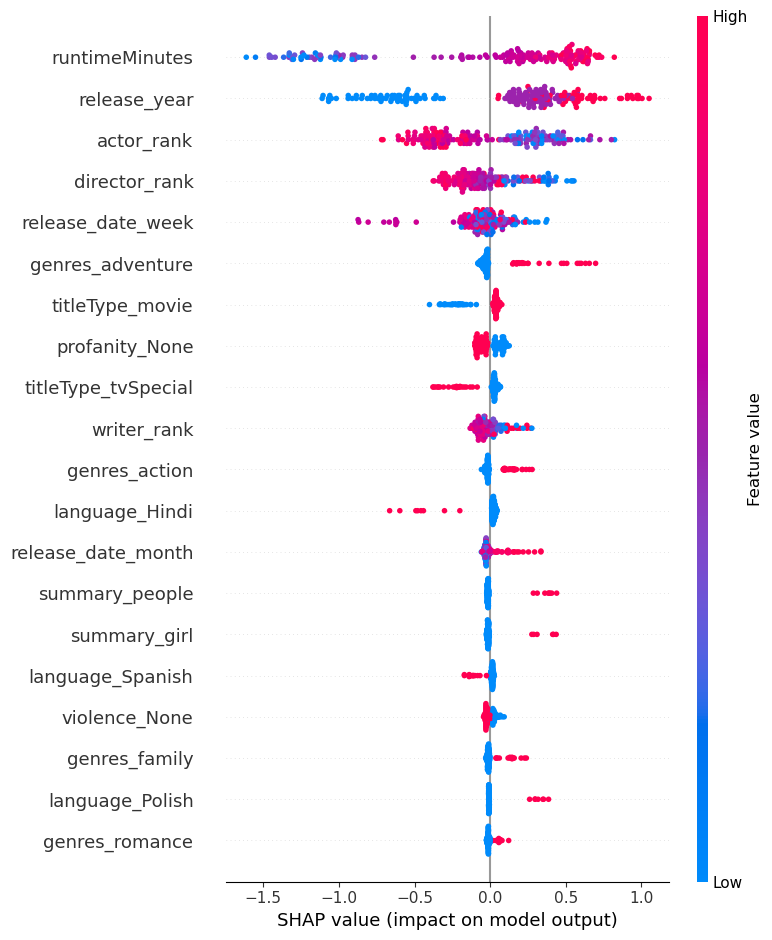

In [26]:
shap.summary_plot(shap_values, pd.DataFrame(best_xgb_gs_bow_drop['xgb_transformer'].transform(X_test.drop(columns=['averageRating', 'numVotes'])).todense(), columns=xgb_gs_bow_drop_feature_names))

In [37]:
explainer.expected_value

0.08277985

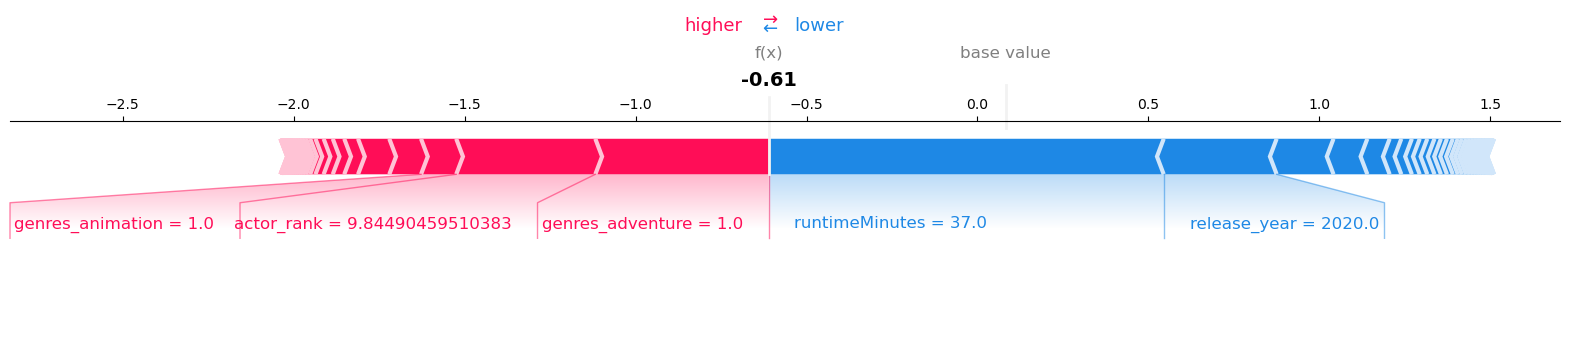

In [36]:
shap.force_plot(explainer.expected_value, shap_values[0,:], pd.DataFrame(best_xgb_gs_bow_drop['xgb_transformer'].transform(X_test.drop(columns=['averageRating', 'numVotes'])).todense(), columns=xgb_gs_bow_drop_feature_names).iloc[0,:], matplotlib=True)

# RANDOM FOREST

## <u>Random Forest : No Summary<u>__________________________________________

In [342]:
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [343]:
rankings_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

rf_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        #("bagofwords", CountVectorizer(stop_words='english', min_df=0.02), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language     # one-hot encode language
    ],
    remainder='passthrough')
        

In [344]:
# make sklearn pipeline with transform, normalization, and model (RF)
rf_pipe = Pipeline(
    steps=[
        ('rf_transformer', rf_transformer),                                                  # Transform dataset                
        #('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        #('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('randomforest', RandomForestClassifier())                                           # Build Decision Tree model
    ]
)

rf_gs_ns = GridSearchCV(
    rf_pipe,
    param_grid={
        'randomforest__n_estimators': [100, 300, 500],
        'randomforest__max_depth': [3, 4, 5, 6, 7],
        'randomforest__min_samples_split': [2, 3, 4],
        'rf_transformer__rankings_pipeline__imputer__n_neighbors': [3, 5, 7, 9, 11],

    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [346]:
# fit rf_gs_ns to training set and drop summary column
rf_gs_ns.fit(X_train.drop(columns=['summary']), y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('genres_count',
                                                                         CountVectorizer(min_df=0.01),
                                                                         'genres'),
                                                                        ('imputer',
                                                                         SimpleImpute...
                                                                                       min_frequency=0.01),
                                                                         ['language'])])),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforest__max_depth': [3, 4, 5, 6, 7],
                         'randomforest__min_samples_split': [2, 3, 4],
                         'randomforest__n_estimators': [100, 300, 500],
                         'rf_transformer__rankings_pipeline__imputer__n_neighbors': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     11]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [356]:
rf_gs_ns.best_params_

{'randomforest__max_depth': 7,
 'randomforest__min_samples_split': 4,
 'randomforest__n_estimators': 500,
 'rf_transformer__rankings_pipeline__imputer__n_neighbors': 5}

In [354]:
# save best rf_gs_ns model as a variable
best_rf_gs_ns = rf_gs_ns.best_estimator_

# output best score from rf_gs_ns
print("Random Forest, No Summary, Best Validation AUC: %0.5f" % rf_gs_ns.best_score_)

preds, prob_preds = get_results_model(best_rf_gs_ns, y_test, "Random Forest, No Summary Test")

# output test set auc, f1-score, and accuracy
# print("Random Forest, No Summary, Test set AUC: %0.5f" % roc_auc_score(tvshows_y_test, best_rf_gs_ns.predict_proba(tvshows_X_test.drop(columns=['summary']))[:,1]))
# print("Random Forest, No Summary, Test set F1: %0.5f" % f1_score(tvshows_y_test, best_rf_gs_ns.predict(tvshows_X_test.drop(columns=['summary']))))
# print("Random Forest, No Summary, Test set Accuracy: %0.5f" % accuracy_score(tvshows_y_test, best_rf_gs_ns.predict(tvshows_X_test.drop(columns=['summary']))))

Random Forest, No Summary, Best Validation AUC: 0.82063
Random Forest, No Summary Test AUC: 0.83333
Random Forest, No Summary Test F1: 0.76329
Random Forest, No Summary Test Accuracy: 0.73370


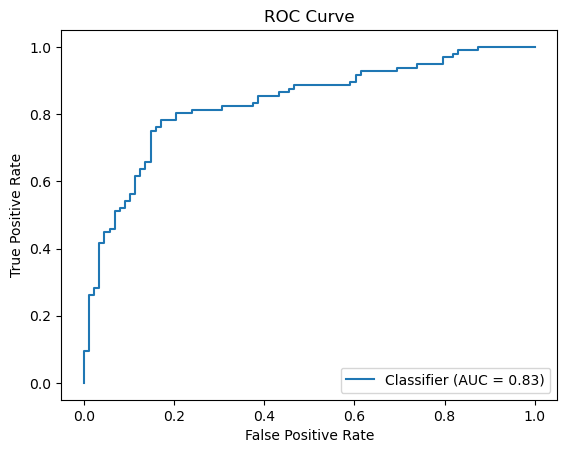

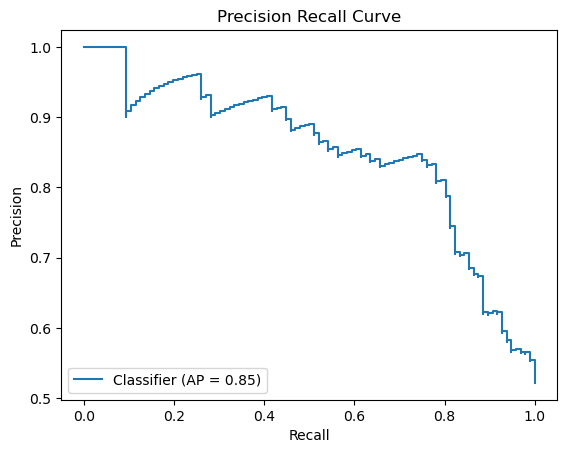

In [355]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_predictions(y_test, prob_preds)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_predictions(y_test, prob_preds)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_rf_ns_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_rf_ns_precision_recall_curve.png')

## <u>Random Forest : Bag of Words<u>_________________________________________

In [360]:
rankings_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

rf_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        ("bagofwords", CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language     # one-hot encode language
    ],
    remainder='passthrough')
        

In [363]:
# make sklearn pipeline with transform, normalization, and model (RF)
rf_pipe = Pipeline(
    steps=[
        ('rf_transformer', rf_transformer),                                                  # Transform dataset                
        #('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        #('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('randomforest', RandomForestClassifier())                                           # Build Decision Tree model
    ]
)

rf_gs_bow = GridSearchCV(
    rf_pipe,
    param_grid={
        'randomforest__n_estimators': [100, 300, 500],
        'randomforest__max_depth': [3, 4, 5, 6, 7],
        'randomforest__min_samples_split': [2, 3, 4],
        'rf_transformer__rankings_pipeline__imputer__n_neighbors': [3, 5, 7],
        
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [364]:
# fit rf_gs_bow to training set
rf_gs_bow.fit(X_train, y_train)

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('bagofwords',
                                                                         CountVectorizer(stop_words='english',
                                                                                         tokenizer=<__main__.LemmaTo...
                                                                                       min_frequency=0.01),
                                                                         ['language'])])),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforest__max_depth': [3, 4, 5, 6, 7],
                         'randomforest__min_samples_split': [2, 3, 4],
                         'randomforest__n_estimators': [100, 300, 500],
                         'rf_transformer__rankings_pipeline__imputer__n_neighbors': [3,
                                                                                     5,
                                                                                     7]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [368]:
rf_gs_bow.best_params_

{'randomforest__max_depth': 7,
 'randomforest__min_samples_split': 3,
 'randomforest__n_estimators': 300,
 'rf_transformer__rankings_pipeline__imputer__n_neighbors': 3}

In [366]:
# save best rf_gs_ns model as a variable
best_rf_gs_bow = rf_gs_bow.best_estimator_

# output best score from rf_gs_ns
print("Random Forest, No Summary, Best Validation AUC: %0.5f" % rf_gs_bow.best_score_)

preds, prob_preds = get_results_model(best_rf_gs_bow, y_test, "Random Forest, No Summary Test")


Random Forest, No Summary, Best Validation AUC: 0.76803
Random Forest, No Summary Test AUC: 0.78042
Random Forest, No Summary Test F1: 0.75000
Random Forest, No Summary Test Accuracy: 0.70652


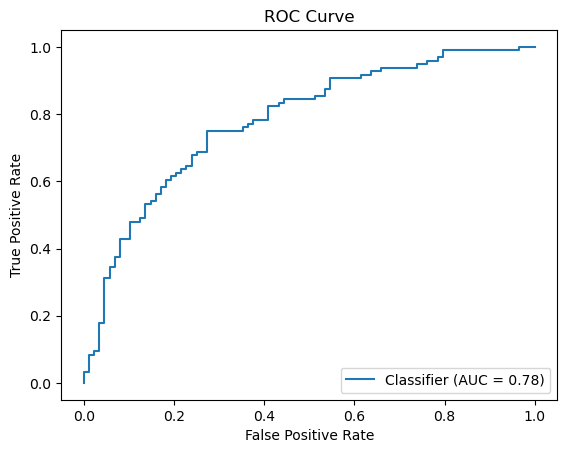

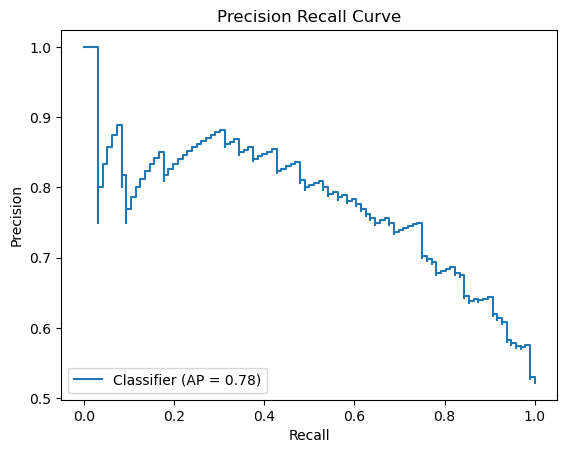

In [367]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_predictions(y_test, prob_preds)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_predictions(y_test, prob_preds)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_rf_bow_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_rf_bow_precision_recall_curve.png')

## <u>Random Forest : TFIDF<u>_________________________________________________

In [371]:
rankings_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))  
])

rf_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        #("bagofwords", CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True), 'summary'),              # One hot encoding
        ("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language     # one-hot encode language
    ],
    remainder='passthrough')
        

In [377]:
# make sklearn pipeline with transform, normalization, and model (RF)
rf_pipe = Pipeline(
    steps=[
        ('rf_transformer', rf_transformer),                                                  # Transform dataset                
        #('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        #('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('randomforest', RandomForestClassifier())                                           # Build Decision Tree model
    ]
)

rf_gs_tfidf = GridSearchCV(
    rf_pipe,
    param_grid={
        'randomforest__n_estimators': [100, 300, 500],
        'randomforest__max_depth': [6, 7],
        'randomforest__min_samples_leaf': [20, 30, 40],
        'rf_transformer__tfidf__min_df': [0.04, 0.05, 0.06],
        'rf_transformer__rankings_pipeline__imputer__n_neighbors': [5, 10, 15],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [378]:
# fit rf_gs_tfidf to training set
rf_gs_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('tfidf',
                                                                         TfidfVectorizer(min_df=0.02,
                                                                                         stop_words='english'),
                                                                         'summary'),
                                                                        ('genres...
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforest__max_depth': [6, 7],
                         'randomforest__min_samples_leaf': [20, 30, 40],
                         'randomforest__n_estimators': [100, 300, 500],
                         'rf_transformer__rankings_pipeline__imputer__n_neighbors': [5,
                                                                                     10,
                                                                                     15],
                         'rf_transformer__tfidf__min_df': [0.04, 0.05, 0.06]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [381]:
# save best xgb_gs_tfidf model as a variable
best_rf_gs_tfidf = rf_gs_tfidf.best_estimator_

# output best score from xgb_gs_tfidf
print("XGBoost TF-IDF, Best score: %0.5f" % rf_gs_tfidf.best_score_)

preds, prob_preds = get_results_model(best_rf_gs_tfidf, y_test, "Random Forest, TFIDF Test")

# # output test set auc, f1-score, and accuracy
# print("XGBoost TF-IDF, Test set AUC: %0.5f" % roc_auc_score(y_test, best_rf_gs_tfidf.predict_proba(X_test)[:,1]))
# print("XGBoost TF-IDF, Test set F1: %0.5f" % f1_score(y_test, best_rf_gs_tfidf.predict(X_test)))
# print("XGBoost TF-IDF, Test set Accuracy: %0.5f" % accuracy_score(y_test, best_rf_gs_tfidf.predict(X_test)))

XGBoost TF-IDF, Best score: 0.79848
Random Forest, TFIDF Test AUC: 0.81937
Random Forest, TFIDF Test F1: 0.75598
Random Forest, TFIDF Test Accuracy: 0.72283


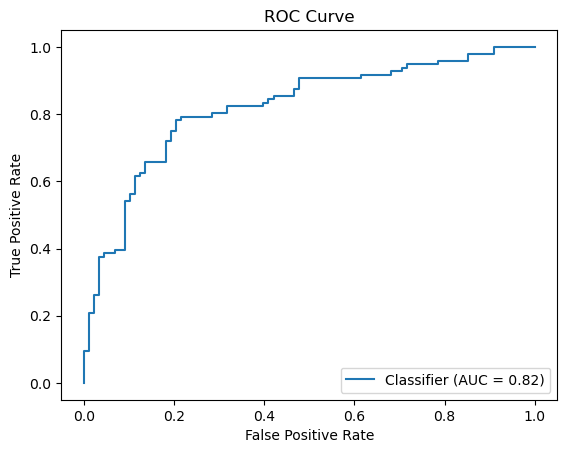

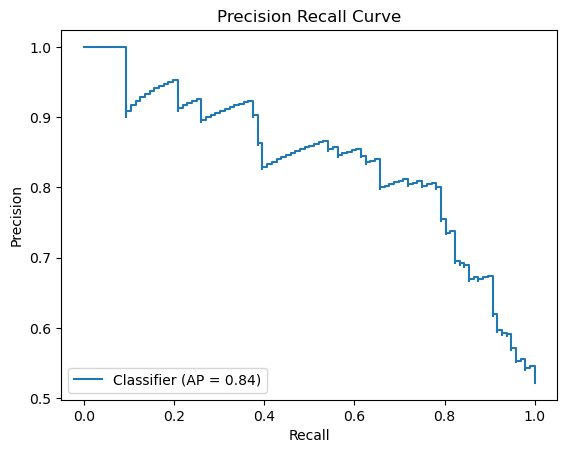

In [382]:
# plot roc-auc curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

rocplot = RocCurveDisplay.from_predictions(y_test, prob_preds)
rocplot.ax_.set_xlabel('False Positive Rate')
rocplot.ax_.set_ylabel('True Positive Rate')
rocplot.ax_.set_title('ROC Curve')

# plot precision recall curve
from sklearn.metrics import PrecisionRecallDisplay

prplot = PrecisionRecallDisplay.from_predictions(y_test, prob_preds)
prplot.ax_.set_xlabel('Recall')
prplot.ax_.set_ylabel('Precision')
prplot.ax_.set_title('Precision Recall Curve')

# save roc-auc and precision-recall curve into reports/figures folder

rocplot.figure_.savefig('../reports/figures/movie_rf_tfidf_roc_auc_curve.png')
prplot.figure_.savefig('../reports/figures/movie_rf_tfidf_precision_recall_curve.png')

## Print all Model Scores (XGBoost and Random Forest)

In [111]:
# print all models best scores: xgboost no summary, bow, tfidf, and random forest no summary, bow, tfidf
print("XGBoost, No Summary, Best score: %0.5f" % xgb_gs_ns.best_score_)
print("XGBoost, Bag of Words, Best score: %0.5f" % xgb_gs_bow.best_score_)
print("XGBoost, TF-IDF, Best score: %0.5f" % xgb_gs_tfidf.best_score_)
print("Random Forest, No Summary, Best score: %0.5f" % rf_gs_ns.best_score_)
print("Random Forest, Bag of Words, Best score: %0.5f" % rf_gs_bow.best_score_)
print("Random Forest, TF-IDF, Best score: %0.5f" % rf_gs_tfidf.best_score_)

XGBoost, No Summary, Best score: 0.82043
XGBoost, Bag of Words, Best score: 0.82264
XGBoost, TF-IDF, Best score: 0.82749
Random Forest, No Summary, Best score: 0.75035
Random Forest, Bag of Words, Best score: 0.74502
Random Forest, TF-IDF, Best score: 0.74749


Of these 6 model derivatives of XGBoost and Random Forest, we would choose <u>**XGBoost TF-IDF**<u>

## Generate ICE Plots vs Season

In [113]:
# get tvshows_X dataset by dropping 'is_top10' variable
tvshows_X = tv_shows.drop(columns=['is_top10'])

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


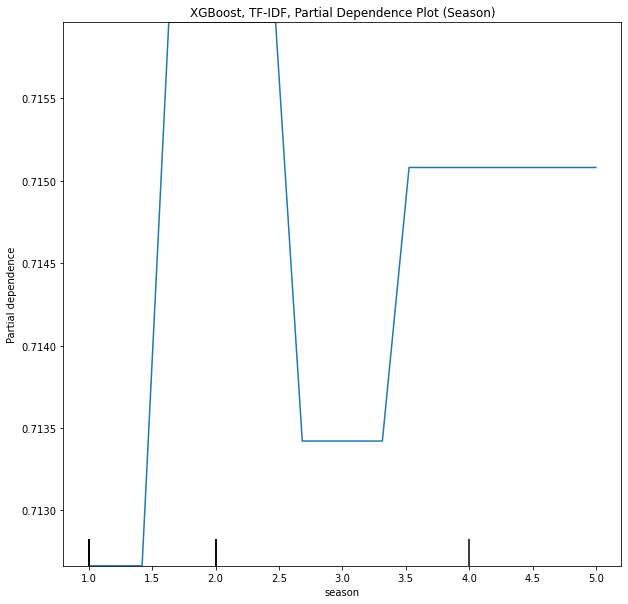

In [125]:
# generate ice plots for xgboost, tfidf vs. season column
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 10))
plot_partial_dependence(
    best_xgb_gs_tfidf,
    tvshows_X,
    ["season"],
    ax=ax,
    grid_resolution=20,
    n_jobs=-1,
)
plt.title('XGBoost, TF-IDF, Partial Dependence Plot (Season)')
plt.show()

## Check Distributions of Training and Test Sets

In [126]:
X_train = tvshows_X_train.copy()
X_test = tvshows_X_test.copy()

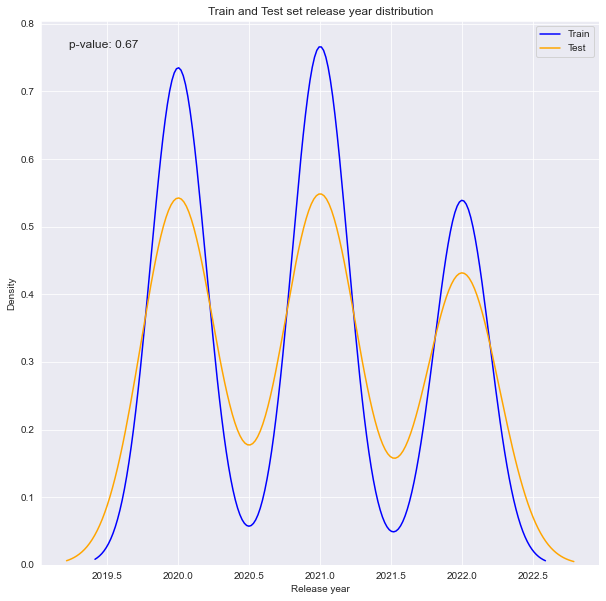

In [146]:
#Make sure the train and test set release year distribution is not statistically different

from scipy.stats import ttest_ind

ttest_ind(X_train['release_year'], X_test['release_year'])

#Now plot it

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(X_train['release_year'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['release_year'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set release year distribution')
ax.set_xlabel('Release year')
ax.set_ylabel('Density')
ax.legend()
ax.annotate(f'p-value: {ttest_ind(X_train["release_year"], X_test["release_year"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [128]:
#Calculate chi2 for release_date_month

from scipy.stats import chi2_contingency

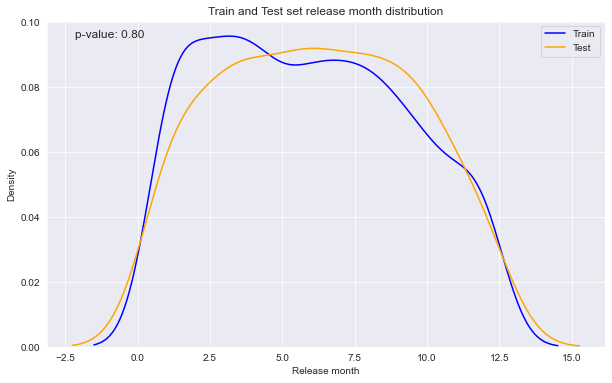

In [147]:
#Plot and compare the train and test set release month distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['release_date_month'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['release_date_month'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set release month distribution')
ax.set_xlabel('Release month')
ax.set_ylabel('Density')
ax.legend()

#Annotate chi2 test result
chi2, p, dof, expected = chi2_contingency(pd.DataFrame({"train": X_train['release_date_month'].value_counts().sort_index(), "test": X_test['release_date_month'].value_counts().sort_index()}))
ax.annotate(f'p-value: {p:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

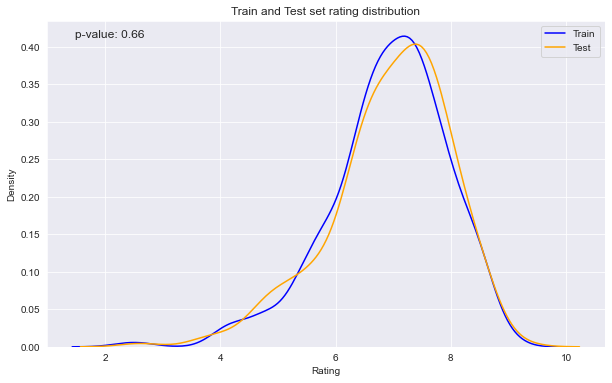

In [140]:
#Plot and compare the train and test set rating distribution



fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['averageRating'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['averageRating'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set rating distribution')
ax.set_xlabel('Rating')
ax.set_ylabel('Density')
# add legend
ax.legend()

# Annotate p-value
ax.annotate(f'p-value: {ttest_ind(X_train["averageRating"], X_test["averageRating"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

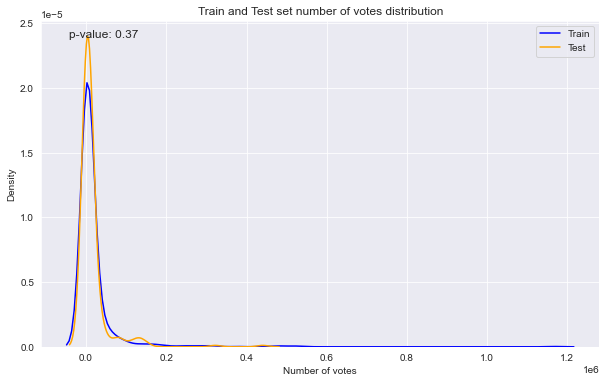

In [141]:
# Plot and compare the train and test set number of votes distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['numVotes'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['numVotes'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set number of votes distribution')
ax.set_xlabel('Number of votes')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["numVotes"], X_test["numVotes"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
ax.legend()
plt.show()

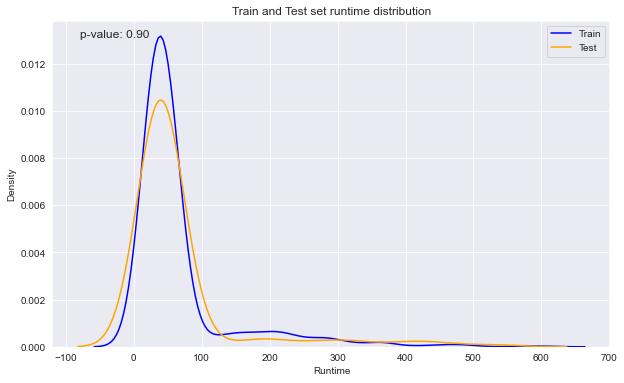

In [142]:
#Plot and compare the train and test set runtime distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['runtimeMinutes'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['runtimeMinutes'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set runtime distribution')
ax.set_xlabel('Runtime')
ax.set_ylabel('Density')
ax.legend()
ax.annotate(f'p-value: {ttest_ind(X_train["runtimeMinutes"].dropna(), X_test["runtimeMinutes"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

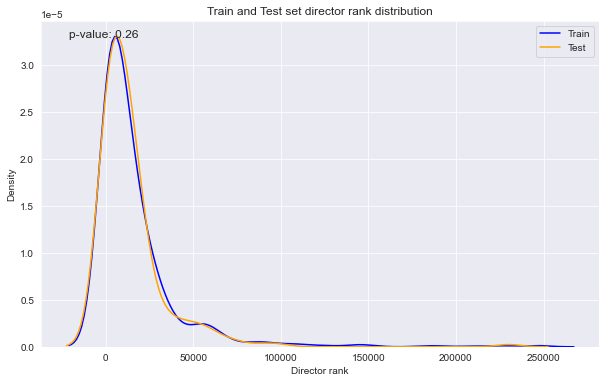

In [143]:
# Plot and compare the train and test set director rank distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['director_rank'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['director_rank'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set director rank distribution')
ax.set_xlabel('Director rank')
ax.set_ylabel('Density')
ax.legend()
ax.annotate(f'p-value: {ttest_ind(X_train["director_rank"].dropna(), X_test["director_rank"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

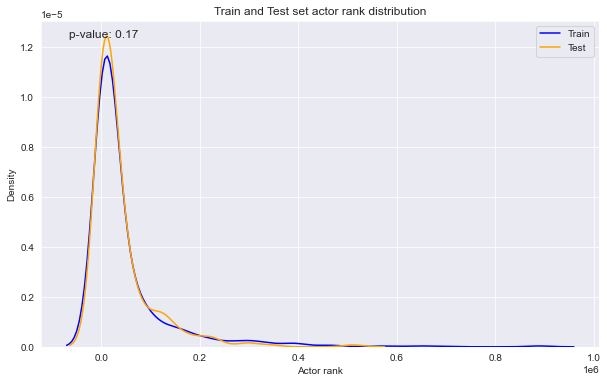

In [144]:
# Plot and compare the train and test set actor distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['actor_rank'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['actor_rank'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set actor rank distribution')
ax.set_xlabel('Actor rank')
ax.set_ylabel('Density')
ax.legend()
ax.annotate(f'p-value: {ttest_ind(X_train["actor_rank"].dropna(), X_test["actor_rank"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()


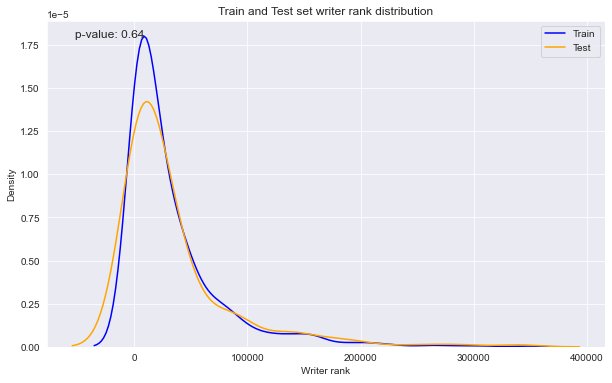

In [145]:
# Plot and compare the train and test set writer distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['writer_rank'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['writer_rank'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set writer rank distribution')
ax.set_xlabel('Writer rank')
ax.set_ylabel('Density')
ax.legend()
ax.annotate(f'p-value: {ttest_ind(X_train["writer_rank"].dropna(), X_test["writer_rank"].dropna())[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

### Bag of Words for Genres

In [136]:
from sklearn.feature_extraction.text import CountVectorizer

#Create a count vectorizer to count the number of words in the genres column
count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.99, binary=True, token_pattern=r'(?u)[a-zA-Z][a-z -]+')
count_vectorizer.fit(X_train['genres'])

CountVectorizer(binary=True, max_df=0.99, min_df=0.05,
                token_pattern='(?u)[a-zA-Z][a-z -]+')

In [137]:
#Transform the genres column
genres_train = count_vectorizer.transform(X_train['genres'])
#Convert to a dataframe
genres_train = pd.DataFrame(genres_train.todense(), columns=count_vectorizer.get_feature_names_out())

#Transform the genres column
genres_test = count_vectorizer.transform(X_test['genres'])
#Convert to a dataframe
genres_test = pd.DataFrame(genres_test.todense(), columns=count_vectorizer.get_feature_names_out())

In [138]:
train_genres_temp = pd.DataFrame({"percent_counts": genres_train.sum()/genres_train.sum().sum(), "type": "train"}).reset_index()
test_genres_temp = pd.DataFrame({"percent_counts": genres_test.sum()/genres_test.sum().sum(), "type": "test"}).reset_index()

genres_temp = pd.concat([train_genres_temp, test_genres_temp], axis=0)

Text(0.05, 0.95, 'p-value: 0.88')

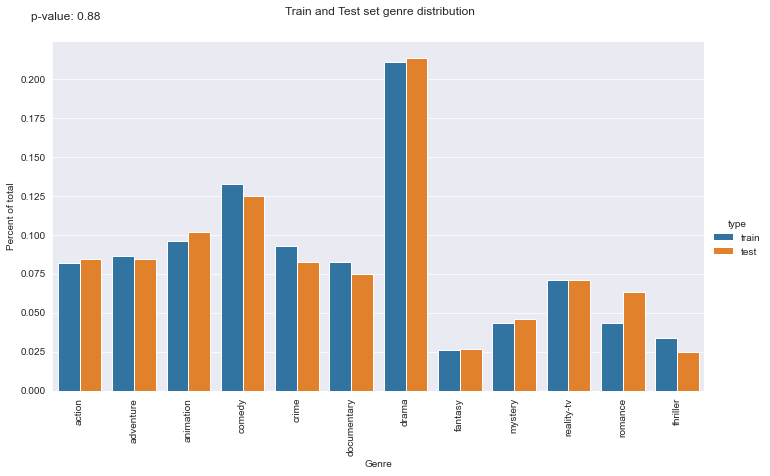

In [139]:
#plot the train and test set genre distributions with offset to see if they are similar

ax = sns.catplot(y='percent_counts', x='index', hue='type', data=genres_temp, kind='bar', height=6, aspect=10/6)

ax.set_xticklabels(rotation=90)

#annotate a chi square test to see if the distributions are statistically different

from scipy.stats import chi2_contingency

chi2_contingency([genres_train.sum(), genres_test.sum()])
ax.set_axis_labels('Genre', 'Percent of total')
ax.fig.suptitle('Train and Test set genre distribution')
ax.fig.subplots_adjust(top=0.9)
ax.fig.text(0.05, 0.95, f'p-value: {chi2_contingency([genres_train.sum(), genres_test.sum()])[1]:.2f}', fontsize=12)